In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras.regularizers import L2
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-10-07 19:06:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-10-07 19:06:24 (109 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [6]:
input_sequences[0:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  34, 417],
       [  0,   0,   0,   0,   0,   0,   0,   0,  34, 417, 877],
       [  0,   0,   0,   0,   0,   0,   0,  34, 417, 877, 166],
       [  0,   0,   0,   0,   0,   0,  34, 417, 877, 166, 213],
       [  0,   0,   0,   0,   0,  34, 417, 877, 166, 213, 517]],
      dtype=int32)

In [7]:
label[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
model = Sequential()
model.add(Embedding(total_words,64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(40, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(40)))
model.add(Dense(512, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 64)            205504    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 80)            33600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 80)                38720     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               41472     
_________________________________________________________________
dense_7 (Dense)              (None, 3211)              1647243   
Total params: 1,966,539
Trainable params: 1,966,539
Non-trainable params: 0
____________________________________________

In [18]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 6s 12ms/step - loss: 6.8720 - accuracy: 0.0203
Epoch 2/100
484/484 [==============================] - 6s 12ms/step - loss: 6.4965 - accuracy: 0.0250
Epoch 3/100
484/484 [==============================] - 6s 12ms/step - loss: 6.3226 - accuracy: 0.0333
Epoch 4/100
484/484 [==============================] - 6s 12ms/step - loss: 6.1946 - accuracy: 0.0356
Epoch 5/100
484/484 [==============================] - 6s 12ms/step - loss: 6.0491 - accuracy: 0.0385
Epoch 6/100
484/484 [==============================] - 6s 12ms/step - loss: 5.8791 - accuracy: 0.0430
Epoch 7/100
484/484 [==============================] - 6s 12ms/step - loss: 5.7196 - accuracy: 0.0482
Epoch 8/100
484/484 [==============================] - 6s 12ms/step - loss: 5.5553 - accuracy: 0.0537
Epoch 9/100
484/484 [==============================] - 6s 12ms/step - loss: 5.3882 - accuracy: 0.0597
Epoch 10/100
484/484 [==============================] - 6s 12ms/step - loss: 5.221

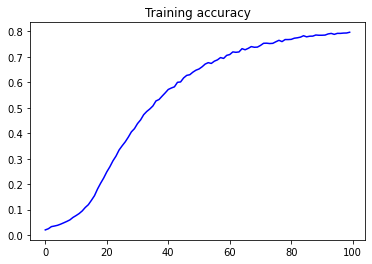

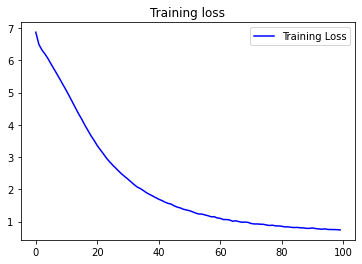

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [20]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope to gentle delight my heart ' torn torn doth dwell my heart ' new i fall in me heart the cheer by eyes it seen lie to thy heart of kings thine 'will ' ' sweet view not live thy state enjoys it dear friend ' lie on my moan me my mind with brow doth doth lie on my mind not kings see so heart so the worst of 'will ' fair for thee my mind of bring to mend thee to truth and gone days in me store me day oppress'd me strange dearer fine herd of of
